In [2]:
import numpy as np 
import pandas as pd
import torch
import tiktoken 

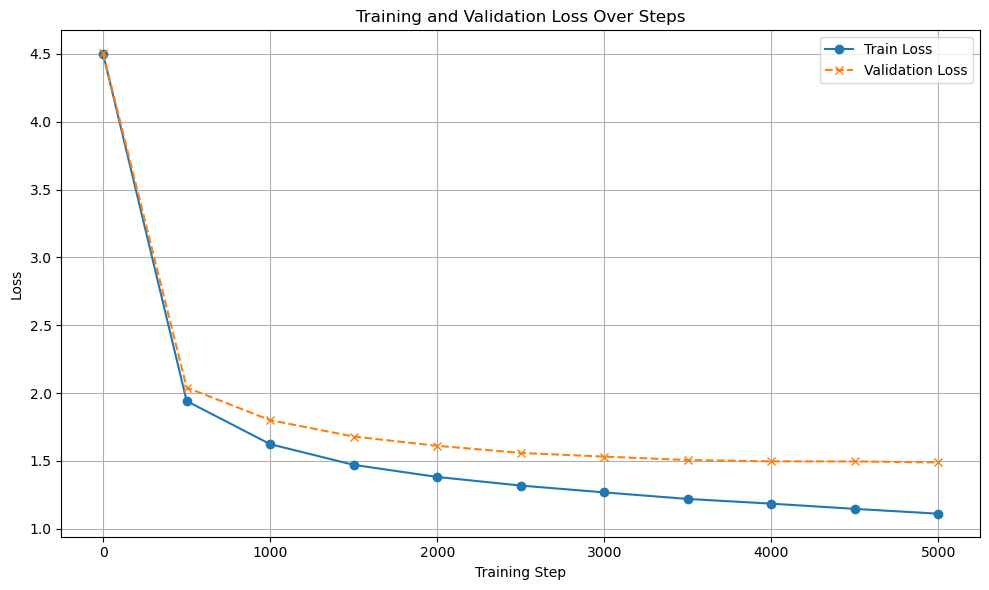

In [115]:
import matplotlib.pyplot as plt
import pandas as pd
import io

# Data provided in the markdown table
data = """
Step | Train Loss | Val Loss
------|------------|----------
0     | 4.4980     | 4.5034
500   | 1.9412     | 2.0405
1000  | 1.6235     | 1.8004
1500  | 1.4709     | 1.6795
2000  | 1.3818     | 1.6115
2500  | 1.3184     | 1.5588
3000  | 1.2681     | 1.5318
3500  | 1.2199     | 1.5068
4000  | 1.1852     | 1.4971
4500  | 1.1466     | 1.4965
4999  | 1.1111     | 1.4888
"""

# Read the data into a pandas DataFrame
df = pd.read_csv(io.StringIO(data), sep='|', skipinitialspace=True)

# Clean up DataFrame (remove extra spaces and empty columns from markdown table parsing)
df.columns = [col.strip() for col in df.columns]
df = df.iloc[1:] # Skip the separator line
df = df[['Step', 'Train Loss', 'Val Loss']] # Select only relevant columns
df = df.apply(pd.to_numeric, errors='coerce') # Convert to numeric

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(df['Step'], df['Train Loss'], label='Train Loss', marker='o', linestyle='-')
plt.plot(df['Step'], df['Val Loss'], label='Validation Loss', marker='x', linestyle='--')

plt.title('Training and Validation Loss Over Steps')
plt.xlabel('Training Step')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()
plt.tight_layout() # Adjust layout to prevent labels from overlapping

# Save the plot
plot_filename = 'loss_plot.png'
plt.savefig(plot_filename)

### Playing around with Pytorch

In [ ]:
x = np.array([[1,2,3]])
print(x.shape)
x

In [ ]:
y = np.array([[1],[2],[3]])
print(y.shape)
y

In [ ]:
x + y

In [ ]:
torch.__version__

In [ ]:
torch.cuda.is_available()

In [ ]:
# create a 0D tensor (scalar) from a Python integer
tensor0d = torch.tensor(1)

# create a 1D tensor (vector) from a Python list
tensor1d = torch.tensor([1, 2, 3])

# create a 2D tensor from a nested Python list
tensor2d = torch.tensor([[1, 2, 3], [4, 5, 6]])

# create a 3D tensor from a nested Python list
tensor3d = torch.tensor([[[1, 2], [3, 4]], [[5, 6], [7, 8]]])

In [ ]:
tensor2d

In [ ]:
tensor2d.T

In [ ]:
import torch.nn.functional as F
from torch.autograd import grad

y = torch.tensor([1.0])
x1 = torch.tensor([1.1])
w1 = torch.tensor([2.2], requires_grad=True)
b = torch.tensor([0.0], requires_grad=True)

z = x1 * w1 + b
a = torch.sigmoid(z)

loss = F.binary_cross_entropy(a, y)

loss.backward()

print(w1.grad)
print(b.grad)

In [ ]:
class NeuralNetwork(torch.nn.Module):
    def __init__(self, num_inputs, num_outputs):
        super().__init__()

        self.layers = torch.nn.Sequential(

            # 1st hidden layer
            torch.nn.Linear(num_inputs, 30),
            torch.nn.ReLU(),

            # 2nd hidden layer
            torch.nn.Linear(30, 20),
            torch.nn.ReLU(),

            # output layer
            torch.nn.Linear(20, num_outputs),
        )

    def forward(self, x):
        logits = self.layers(x)
        return logits

In [ ]:
torch.manual_seed(123)
model = NeuralNetwork(50, 3)
print(model)
num_params = sum(
    p.numel() for p in model.parameters() if p.requires_grad
)
print("Total number of trainable model parameters:", num_params)

In [ ]:
model.layers[0].weight

In [ ]:
print(model.layers[0].weight.shape)

In [ ]:
torch.manual_seed(123)

X = torch.rand((1, 50))
with torch.no_grad():
    out = model(X)
print(out)

In [ ]:
X_train = torch.tensor([
    [-1.2, 3.1],
    [-0.9, 2.9],
    [-0.5, 2.6],
    [2.3, -1.1],
    [2.7, -1.5]
])

y_train = torch.tensor([0, 0, 0, 1, 1])

X_test = torch.tensor([
    [-0.8, 2.8],
    [2.6, -1.6],
])

y_test = torch.tensor([0, 1])

In [ ]:
from torch.utils.data import Dataset


class ToyDataset(Dataset):
    def __init__(self, X, y):
        self.features = X
        self.labels = y

    def __getitem__(self, index):
        one_x = self.features[index]
        one_y = self.labels[index]
        return one_x, one_y

    def __len__(self):
        return self.labels.shape[0]


train_ds = ToyDataset(X_train, y_train)
test_ds = ToyDataset(X_test, y_test)

In [ ]:
from torch.utils.data import DataLoader

torch.manual_seed(123)

train_loader = DataLoader(
    dataset=train_ds,
    batch_size=2,
    shuffle=True,
    num_workers=0,
    drop_last=True
)

test_loader = DataLoader(
    dataset=test_ds,
    batch_size=2,
    shuffle=False,
    num_workers=0,
    drop_last=True
)

for idx, (x, y) in enumerate(train_loader):
    print(f"Batch {idx+1}:", x, y)

In [ ]:
torch.manual_seed(123)
model = NeuralNetwork(num_inputs=2,num_outputs=2)

#device = torch.device('cuda')
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # considered pytorch best practice
model.to(device)

optimizer = torch.optim.SGD(model.parameters(),lr=0.5)
epochs = 3

for epoch in range(epochs):

    model.train()

    for batch_idx, (features,labels) in enumerate(train_loader):
        features,labels = features.to(device), labels.to(device)

        logits = model(features)
        loss = F.cross_entropy(logits,labels)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        print(f"Epoch: {epoch+1:03d}/{epochs:03d}" f" | Batch {batch_idx:03d}/{len(train_loader):03d}" f" | Train/Val Loss: {loss:.2f}")
      
    model.eval()

In [ ]:
# can make predictions
model.eval()
with torch.no_grad():
    outputs = model(X_train) # logits
print(outputs)

torch.set_printoptions(sci_mode=False) 
probs = torch.softmax(outputs,dim=1) # class probas
print(probs)

preds = torch.argmax(probs,dim=1) # convert probas to class preds
print(preds)
 
preds = torch.argmax(outputs,dim=1) # could also get preds direct from logits
print(preds)

In [ ]:
(torch.sum(preds == y_train) / len(y_train))*100 # acc

In [ ]:
for key in model.state_dict(): 
    print(key)

In [ ]:
torch.save(model.state_dict(),"model_test.pth")

In [ ]:
model = NeuralNetwork(2,2)
model.load_state_dict(torch.load("model_test.pth", weights_only=True))

In [ ]:
#model = MyTransformerDecoderModel(...)
#model = model.half().cuda()  # Use float16 to save VRAM

# Check memory usage
#print(torch.cuda.memory_allocated() / 1024 ** 2, "MB allocated")

In [ ]:
x = torch.randn(2,2,3)
y = torch.randn(2,2,3)
y = y.view()
print(x)
print(x.shape)
print("")
print(y)
print(y.shape)

In [ ]:
enc = tiktoken.get_encoding("gpt2")
vocab_size = enc.n_vocab
print(f"Vocab size: {vocab_size}")
es = enc.encode("Hello, Marcus Aurelius.")
print(es)
ds = enc.decode(es)
print(ds)

In [22]:
x = torch.randn(1,2,4)
#x = torch.randn(10,123,132)

tensor([[[0.3603, 0.3144, 0.1700, 0.1553],
         [0.0653, 0.1383, 0.1937, 0.6027]]])

In [25]:
torch.argmax(x,-1,True)

tensor([[[0],
         [3]]])

In [27]:
target  = torch.randn(1,2,1)
target

tensor([[[-0.1727],
         [ 1.2632]]])

In [28]:
x.view(-1,4)

tensor([[ 0.9615,  0.8252,  0.2104,  0.1198],
        [-1.1032, -0.3533, -0.0164,  1.1190]])

### Tokenizer/Input Batching

In [31]:
with open('input.txt', 'r', encoding='utf-8') as f:
    text = f.read()


In [33]:
# use character level tokenizer so classification head param count stays small
chars = sorted(list(set(text)))
vocab_size = len(chars)

# create a mapping from characters to integers
stoi = { ch:i for i,ch in enumerate(chars) }
itos = { i:ch for i,ch in enumerate(chars) }

encode = lambda s: [stoi[c] for c in s] # encoder: take a string, output a list of integers
decode = lambda l: ''.join([itos[i] for i in l]) # decoder: take a list of integers, output a string

In [36]:
# Train and test splits
data = torch.tensor(encode(text), dtype=torch.long)
n = int(0.9*len(data)) # first 90% will be train, rest val
train_data = data[:n]
val_data = data[n:]

In [38]:
len(data),len(train_data),len(val_data) # trained on about 1 mil tokens

(1115394, 1003854, 111540)

In [41]:
B = 64 # batch size
T = 256 # sequence length i.e. chunk size

# data loading
def get_batch(split):
    # generate a small batch of data of inputs x and targets y
    data = train_data if split == 'train' else val_data
    ix = torch.randint(len(data) - T, (B,))
    x = torch.stack([data[i:i+T] for i in ix])
    y = torch.stack([data[i+1:i+T+1] for i in ix])
    #x, y = x.to(device), y.to(device)
    return x, y

In [58]:
decode(data[895115:895115+T].tolist())

", thou art death's fool;\nFor him thou labour'st by thy flight to shun\nAnd yet runn'st toward him still. Thou art not noble;\nFor all the accommodations that thou bear'st\nAre nursed by baseness. Thou'rt by no means valiant;\nFor thou dost fear the soft and te"

In [59]:
decode(data[895115+1:895115+T+1].tolist())

" thou art death's fool;\nFor him thou labour'st by thy flight to shun\nAnd yet runn'st toward him still. Thou art not noble;\nFor all the accommodations that thou bear'st\nAre nursed by baseness. Thou'rt by no means valiant;\nFor thou dost fear the soft and ten"

In [60]:
decode([0]) # "start" char

'\n'

In [49]:
ix = torch.randint(len(data) - T, (B,))
ix

tensor([ 895115,  246623,  938882,   78427,  129300,  238216,  398633,  837676,
         350772,  533631,  138847,  761428,  715140,  290883,  164923,  145248,
         119769,   57340,   54342,   47087,  482750,  824068,  632951,  513954,
         503000,  303951,  876086,  103905,  770729,  401111,  226073,  173709,
        1084658,  105248,  190882, 1012019, 1071803,   62116,  824877,  162736,
        1053234,  132077,  167731,  321861,  462900,  215859,  928857,  956382,
         317156,  556775,  982432,  820158,  610316, 1000956,  856303,  404046,
         362151,  377803,  222158,  741610, 1023730,  463589,  769318,  807891])

In [45]:
x,y = get_batch('split')
print(x.shape)
print(y.shape)
x[0]


torch.Size([64, 256])
torch.Size([64, 256])


tensor([39, 58, 11,  0, 24, 39, 57, 58,  1, 52, 47, 45, 46, 58,  1, 57, 46, 43,
         1, 57, 50, 43, 54, 58,  1, 52, 53, 58,  6,  1, 52, 53, 56,  1, 58, 53,
         7, 52, 47, 45, 46, 58,  1, 57, 46, 43,  1, 57, 46, 39, 50, 50,  1, 52,
        53, 58, 11,  0, 13, 57,  1, 61, 47, 58, 46,  1, 58, 46, 43,  1, 51, 43,
        39, 58,  6,  1, 57, 53, 51, 43,  1, 59, 52, 42, 43, 57, 43, 56, 60, 43,
        42,  1, 44, 39, 59, 50, 58,  0, 21,  5, 50, 50,  1, 44, 47, 52, 42,  1,
        39, 40, 53, 59, 58,  1, 58, 46, 43,  1, 51, 39, 49, 47, 52, 45,  1, 53,
        44,  1, 58, 46, 43,  1, 40, 43, 42, 11,  0, 13, 52, 42,  1, 46, 43, 56,
        43,  1, 21,  5, 50, 50,  1, 44, 50, 47, 52, 45,  1, 58, 46, 43,  1, 54,
        47, 50, 50, 53, 61,  6,  1, 58, 46, 43, 56, 43,  1, 58, 46, 43,  1, 40,
        53, 50, 57, 58, 43, 56,  6,  0, 32, 46, 47, 57,  1, 61, 39, 63,  1, 58,
        46, 43,  1, 41, 53, 60, 43, 56, 50, 43, 58,  6,  1, 39, 52, 53, 58, 46,
        43, 56,  1, 61, 39, 63,  1, 58, 

In [69]:
T = 2
d = 4

idx,y = get_batch('train')

token_embedding_table = torch.nn.Embedding(vocab_size, d)
position_embedding_table = torch.nn.Embedding(T, d)
tok_emb = token_embedding_table(idx) 
print(tok_emb.shape)
pos_emb = position_embedding_table(torch.arange(T)) 
print(pos_emb.shape)
x = tok_emb + pos_emb 

torch.Size([64, 2, 4])
torch.Size([2, 4])


torch.Size([64, 2, 4])

In [77]:
target = torch.rand(2,2)
target.view(2*2)

tensor([0.1908, 0.9770, 0.0169, 0.3878])

In [81]:
logits = torch.randn(2*2,vocab_size)
targets = torch.tensor([1, 5, 2, 8], dtype=torch.long)
loss = torch.nn.functional.cross_entropy(logits,targets)
print(loss)
test = loss + 1
print(test)

tensor(4.3657)
tensor(5.3657)


In [85]:
idx = torch.randn(1,20)
idx_cond = idx[:, -4:]
idx


tensor([[ 0.8303, -1.4623,  1.1412,  0.4153,  0.4056,  0.1991,  0.6061,  1.2064,
          0.3277,  0.3853,  0.0872, -0.8793,  2.1148, -0.9874, -0.1698,  0.3654,
         -1.2701, -0.5737,  1.2273, -0.4307]])

In [86]:
idx_cond

tensor([[-1.2701, -0.5737,  1.2273, -0.4307]])

In [99]:
logits = torch.randn(1,20,65)
last_token_logits = logits[:,-1,:]
last_token_logits

tensor([[-2.7704, -0.7588,  0.7931,  0.2505, -0.7237,  0.4763,  0.7964, -0.7088,
          0.6208,  1.4390, -0.9095,  0.8292,  0.3113,  1.7573,  0.8527, -1.2124,
         -0.4216, -2.3137, -2.1009, -0.8603, -0.2827,  0.0386,  0.9446,  0.8405,
         -0.7156, -0.8320, -0.4195,  1.9317,  0.1444, -0.0942,  0.0306, -1.4142,
         -1.9662, -0.4524, -0.6699, -0.8746, -1.5584, -0.1668, -2.0009, -1.1509,
          1.9669, -1.0551, -0.2072,  1.1079, -1.2416, -0.2138, -1.1885, -0.3012,
          2.1223,  0.5674, -0.1366,  0.0326, -0.5144,  0.4885,  1.7874,  0.9961,
         -0.7641, -0.9303,  1.1609,  0.0762,  0.4651,  0.4696,  0.1165,  2.7182,
         -0.4730]])

In [98]:
probs = torch.nn.functional.softmax(last_token_logits, dim=-1)
probs

tensor([[0.0134, 0.0058, 0.0034, 0.0050, 0.0069, 0.0170, 0.0065, 0.0248, 0.0071,
         0.0134, 0.0100, 0.0007, 0.0053, 0.0061, 0.0087, 0.0055, 0.0051, 0.0114,
         0.0329, 0.0197, 0.0748, 0.0137, 0.0171, 0.1701, 0.0064, 0.0152, 0.0212,
         0.0155, 0.0336, 0.0038, 0.0066, 0.0103, 0.0040, 0.0053, 0.0176, 0.0361,
         0.0009, 0.0103, 0.0023, 0.0241, 0.0013, 0.0015, 0.0046, 0.0123, 0.0071,
         0.0352, 0.0180, 0.0023, 0.0087, 0.0218, 0.0040, 0.0192, 0.0037, 0.0280,
         0.0056, 0.0194, 0.0058, 0.0427, 0.0047, 0.0068, 0.0131, 0.0096, 0.0043,
         0.0082, 0.0143]])

In [105]:
idx_next = torch.multinomial(probs, num_samples=1)
print(idx_next)
print(probs[:,idx_next])

tensor([[23]])
tensor([[[0.1701]]])


In [106]:
import datetime
current_datetime = datetime.datetime.now()
formatted_datetime = current_datetime.strftime("%Y-%m-%d_%H-%M-%S") # format to 'YYYY-MM-DD_HH-MM-SS'
file_name = f"run_{formatted_datetime}.txt"
with open(file_name,'a') as f:
    f.write('hello world')
    f.write("im rohan")

In [107]:
aten = torch.rand(2,2)
print(aten.shape)
aten.view(-1).shape

torch.Size([2, 2])


torch.Size([4])

In [109]:
import time

# --- Start of the code chunk to time ---
start_time = time.perf_counter()

# Your chunk of code goes here
# For demonstration, let's simulate some work
time.sleep(125)

# --- End of the code chunk to time ---
end_time = time.perf_counter()

# Calculate the duration in seconds
duration_seconds = end_time - start_time

# Convert to minutes
duration_minutes = duration_seconds / 60

print(f"The code chunk ran for {duration_minutes:.4f} minutes.")

The code chunk ran for 2.0834 minutes.


### Multi-head tensor

In [163]:
# optimal mha
# no loops, one big matrix 
B = 1 # batch size
T = 2 # sequence length
d = 6 # emebedding dim 
hd = 4 # head dim, in practice it will be d // n_heads
nh = 3 # num heads

#X = torch.randint(low=1,high=9,size=(B,T,d))
X = torch.randn((B,T,d))

In [164]:
qkv_proj = torch.nn.Linear(d,nh*3*hd,bias=True)
QKV = qkv_proj(X)
print(QKV.shape)
QKV # Batch -> Token -> QKV

torch.Size([1, 2, 36])


tensor([[[ 1.2574, -0.7846,  0.3936, -0.4341, -0.4179, -0.0458,  0.9877,
           0.6893, -1.2998,  1.0285, -1.1518,  0.1981, -0.0403,  0.5824,
          -0.5068,  0.7257, -1.0267, -0.7170, -0.2889, -0.6287,  1.2955,
          -0.3769,  0.0822,  0.0309, -0.9782, -0.2365,  0.7350,  0.0412,
          -0.0443,  0.0729,  0.6253, -0.7054, -0.4219,  0.2578, -0.0340,
          -0.1279],
         [-0.9109,  0.1081,  2.0885,  1.7801,  0.8272, -1.1501,  0.0533,
          -0.1626,  0.5959,  0.3374, -0.9624, -0.5353, -0.3025,  0.6125,
          -1.3391,  0.4416,  0.7332,  0.6736, -0.9303,  0.6824, -0.6639,
          -1.2507, -0.9359, -0.6393,  0.1556,  1.6926, -1.0772,  0.6526,
          -0.6809, -0.7154,  0.1486,  0.4977, -0.8210, -2.3055, -0.5277,
           1.8408]]], grad_fn=<ViewBackward0>)

In [165]:
qkv = QKV.view(B,T,nh,3,hd).permute(0,2,1,3,4).contiguous()
print(qkv.shape)
qkv # B, nh, T, 3, hd

#Batch -> Head -> token -> QKV 

torch.Size([1, 3, 2, 3, 4])


tensor([[[[[ 1.2574, -0.7846,  0.3936, -0.4341],
           [-0.4179, -0.0458,  0.9877,  0.6893],
           [-1.2998,  1.0285, -1.1518,  0.1981]],

          [[-0.9109,  0.1081,  2.0885,  1.7801],
           [ 0.8272, -1.1501,  0.0533, -0.1626],
           [ 0.5959,  0.3374, -0.9624, -0.5353]]],


         [[[-0.0403,  0.5824, -0.5068,  0.7257],
           [-1.0267, -0.7170, -0.2889, -0.6287],
           [ 1.2955, -0.3769,  0.0822,  0.0309]],

          [[-0.3025,  0.6125, -1.3391,  0.4416],
           [ 0.7332,  0.6736, -0.9303,  0.6824],
           [-0.6639, -1.2507, -0.9359, -0.6393]]],


         [[[-0.9782, -0.2365,  0.7350,  0.0412],
           [-0.0443,  0.0729,  0.6253, -0.7054],
           [-0.4219,  0.2578, -0.0340, -0.1279]],

          [[ 0.1556,  1.6926, -1.0772,  0.6526],
           [-0.6809, -0.7154,  0.1486,  0.4977],
           [-0.8210, -2.3055, -0.5277,  1.8408]]]]], grad_fn=<CloneBackward0>)

In [166]:
Q = qkv[:,:,:,0,:]
print(Q.shape)
Q

torch.Size([1, 3, 2, 4])


tensor([[[[ 1.2574, -0.7846,  0.3936, -0.4341],
          [-0.9109,  0.1081,  2.0885,  1.7801]],

         [[-0.0403,  0.5824, -0.5068,  0.7257],
          [-0.3025,  0.6125, -1.3391,  0.4416]],

         [[-0.9782, -0.2365,  0.7350,  0.0412],
          [ 0.1556,  1.6926, -1.0772,  0.6526]]]], grad_fn=<SliceBackward0>)

In [167]:
K = qkv[:,:,:,1,:]
print(K.shape)
K

torch.Size([1, 3, 2, 4])


tensor([[[[-0.4179, -0.0458,  0.9877,  0.6893],
          [ 0.8272, -1.1501,  0.0533, -0.1626]],

         [[-1.0267, -0.7170, -0.2889, -0.6287],
          [ 0.7332,  0.6736, -0.9303,  0.6824]],

         [[-0.0443,  0.0729,  0.6253, -0.7054],
          [-0.6809, -0.7154,  0.1486,  0.4977]]]], grad_fn=<SliceBackward0>)

In [169]:
V = qkv[:,:,:,2,:]
print(V.shape)
V

torch.Size([1, 3, 2, 4])


tensor([[[[-1.2998,  1.0285, -1.1518,  0.1981],
          [ 0.5959,  0.3374, -0.9624, -0.5353]],

         [[ 1.2955, -0.3769,  0.0822,  0.0309],
          [-0.6639, -1.2507, -0.9359, -0.6393]],

         [[-0.4219,  0.2578, -0.0340, -0.1279],
          [-0.8210, -2.3055, -0.5277,  1.8408]]]], grad_fn=<SliceBackward0>)

In [168]:
from math import sqrt
AM = Q @ K.transpose(-2,-1) / sqrt(d)
print(AM.shape)
AM

torch.Size([1, 3, 2, 2])


tensor([[[[-0.1633,  0.8304],
          [ 1.4965, -0.4311]],

         [[-0.2801,  0.5427],
          [-0.0079,  0.7095]],

         [[ 0.1864,  0.3939],
          [-0.4154, -0.4704]]]], grad_fn=<DivBackward0>)

In [171]:
mask = torch.triu(torch.ones_like(AM),diagonal=1).bool()
masked_AM = AM.masked_fill(mask,float('-inf')) # masking upper triangle for causal self attention
attn_weights = torch.nn.functional.softmax(masked_AM,dim=-1) # softmax
out = attn_weights @ V
print(out.shape)
out # B, nh, T, hd

torch.Size([1, 3, 2, 4])


tensor([[[[-1.2998,  1.0285, -1.1518,  0.1981],
          [-1.0590,  0.9407, -1.1278,  0.1049]],

         [[ 1.2955, -0.3769,  0.0822,  0.0309],
          [-0.0213, -0.9642, -0.6020, -0.4195]],

         [[-0.4219,  0.2578, -0.0340, -0.1279],
          [-0.6160, -0.9886, -0.2740,  0.8294]]]],
       grad_fn=<UnsafeViewBackward0>)

In [173]:
out_permute  = out.permute(0,2,1,3).contiguous()
#out_permute = out.permute(0,2,1,3) # [B,nh,T,hd] --> [B, T, nh, hd]
if not out_permute.is_contiguous():
    raise Exception('Permuted tensor is not contiguous...')
print(out_permute.shape)
out_permute

torch.Size([1, 2, 3, 4])


tensor([[[[-1.2998,  1.0285, -1.1518,  0.1981],
          [ 1.2955, -0.3769,  0.0822,  0.0309],
          [-0.4219,  0.2578, -0.0340, -0.1279]],

         [[-1.0590,  0.9407, -1.1278,  0.1049],
          [-0.0213, -0.9642, -0.6020, -0.4195],
          [-0.6160, -0.9886, -0.2740,  0.8294]]]], grad_fn=<CloneBackward0>)

In [175]:
out_heads_concat = out_permute.view(B,T,nh*hd) 
print(out_heads_concat.shape)
out_heads_concat

torch.Size([1, 2, 12])


tensor([[[-1.2998,  1.0285, -1.1518,  0.1981,  1.2955, -0.3769,  0.0822,
           0.0309, -0.4219,  0.2578, -0.0340, -0.1279],
         [-1.0590,  0.9407, -1.1278,  0.1049, -0.0213, -0.9642, -0.6020,
          -0.4195, -0.6160, -0.9886, -0.2740,  0.8294]]],
       grad_fn=<ViewBackward0>)

### Playing around with view()

simulate self attention calculation

In [177]:
total = B*T*hd*nh*3
QKV = torch.arange(1,total+1).view(B,T,nh*3*hd)
#QKV = torch.randn(B,T,nh*3*hd)
print(QKV.shape)
QKV # output of linear layer [B,T,KQV*nh*hd]

torch.Size([1, 2, 36])


tensor([[[ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
          18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
          35, 36],
         [37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53,
          54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70,
          71, 72]]])

In [178]:
qkv = QKV.view(B,nh,T,3,hd) 
"""
THIS IS WRONG.
If you look closely, you'll reaize that [0,1,1,:,:] 
is taking information that belongs to the 1st token based on QKV[0,0,:]
So the view is messing things up.
"""
# everything grouped by batch -> head -> sequence -> QKV matrix
print(qkv.shape)
qkv

torch.Size([1, 3, 2, 3, 4])


tensor([[[[[ 1,  2,  3,  4],
           [ 5,  6,  7,  8],
           [ 9, 10, 11, 12]],

          [[13, 14, 15, 16],
           [17, 18, 19, 20],
           [21, 22, 23, 24]]],


         [[[25, 26, 27, 28],
           [29, 30, 31, 32],
           [33, 34, 35, 36]],

          [[37, 38, 39, 40],
           [41, 42, 43, 44],
           [45, 46, 47, 48]]],


         [[[49, 50, 51, 52],
           [53, 54, 55, 56],
           [57, 58, 59, 60]],

          [[61, 62, 63, 64],
           [65, 66, 67, 68],
           [69, 70, 71, 72]]]]])

In [179]:
Q = qkv[:,:,:,0,:] # all Q matrices 
print(Q.shape)
print(Q)

torch.Size([1, 3, 2, 4])
tensor([[[[ 1,  2,  3,  4],
          [13, 14, 15, 16]],

         [[25, 26, 27, 28],
          [37, 38, 39, 40]],

         [[49, 50, 51, 52],
          [61, 62, 63, 64]]]])


In [88]:
K = qkv[:,:,:,1,:] # all K matrices
print(K)
print(K.shape)

tensor([[[[  5,   6,   7,   8],
          [ 17,  18,  19,  20]],

         [[ 29,  30,  31,  32],
          [ 41,  42,  43,  44]],

         [[ 53,  54,  55,  56],
          [ 65,  66,  67,  68]]],


        [[[ 77,  78,  79,  80],
          [ 89,  90,  91,  92]],

         [[101, 102, 103, 104],
          [113, 114, 115, 116]],

         [[125, 126, 127, 128],
          [137, 138, 139, 140]]]])
torch.Size([2, 3, 2, 4])


In [89]:
K_T = qkv[:,:,:,1,:].transpose(-2,-1) # all K matrices transposed
print(K_T)
print(K_T.shape)

tensor([[[[  5,  17],
          [  6,  18],
          [  7,  19],
          [  8,  20]],

         [[ 29,  41],
          [ 30,  42],
          [ 31,  43],
          [ 32,  44]],

         [[ 53,  65],
          [ 54,  66],
          [ 55,  67],
          [ 56,  68]]],


        [[[ 77,  89],
          [ 78,  90],
          [ 79,  91],
          [ 80,  92]],

         [[101, 113],
          [102, 114],
          [103, 115],
          [104, 116]],

         [[125, 137],
          [126, 138],
          [127, 139],
          [128, 140]]]])
torch.Size([2, 3, 4, 2])


In [90]:
V = qkv[:,:,:,2,:]
print(V)
print(V.shape)

tensor([[[[  9,  10,  11,  12],
          [ 21,  22,  23,  24]],

         [[ 33,  34,  35,  36],
          [ 45,  46,  47,  48]],

         [[ 57,  58,  59,  60],
          [ 69,  70,  71,  72]]],


        [[[ 81,  82,  83,  84],
          [ 93,  94,  95,  96]],

         [[105, 106, 107, 108],
          [117, 118, 119, 120]],

         [[129, 130, 131, 132],
          [141, 142, 143, 144]]]])
torch.Size([2, 3, 2, 4])


In [91]:
AM = Q @ K_T
print(AM)
print(AM.shape)
# goal: [B,nh,T,T]

tensor([[[[   70,   190],
          [  382,  1078]],

         [[ 3238,  4510],
          [ 4702,  6550]],

         [[11014, 13438],
          [13630, 16630]]],


        [[[23398, 26974],
          [27166, 31318]],

         [[40390, 45118],
          [45310, 50614]],

         [[61990, 67870],
          [68062, 74518]]]])
torch.Size([2, 3, 2, 2])


In [81]:
from math import sqrt 

AM = AM / sqrt(d) # scale
mask = torch.triu(torch.ones_like(AM),diagonal=1).bool()
masked_AM = AM.masked_fill(mask,float('-inf'))
attn_weights = torch.nn.functional.softmax(masked_AM,dim=-1)
out = attn_weights @ V
print(attn_weights)
print(attn_weights.shape)

tensor([[[[1.0000, 0.0000],
          [0.4933, 0.5067]],

         [[1.0000, 0.0000],
          [0.5234, 0.4766]],

         [[1.0000, 0.0000],
          [0.4966, 0.5034]]],


        [[[1.0000, 0.0000],
          [0.4833, 0.5167]],

         [[1.0000, 0.0000],
          [0.5095, 0.4905]],

         [[1.0000, 0.0000],
          [0.4750, 0.5250]]]])
torch.Size([2, 3, 2, 2])


In [82]:
print(V)
print(V.shape)

tensor([[[[-0.3034,  0.6861, -0.3266,  0.7071],
          [ 1.1179,  0.8013,  0.3003,  0.8634]],

         [[-0.6100,  0.3836,  0.2797,  0.1567],
          [-0.9549,  0.8888,  0.3955, -0.6993]],

         [[ 1.7258, -1.8626, -1.0199, -0.5793],
          [-0.5443, -0.8104, -1.4201,  0.1152]]],


        [[[ 0.6855, -0.4818,  0.5789, -0.2515],
          [ 0.4977, -1.2107,  0.6248, -0.2825]],

         [[-1.2388, -0.0442,  0.0299, -0.1188],
          [ 1.0769, -0.2042, -0.2424, -1.2177]],

         [[-0.5631, -0.5505, -0.3765, -0.9081],
          [ 1.4550,  0.9858, -1.1073, -0.8797]]]])
torch.Size([2, 3, 2, 4])


In [107]:
#print(out)
print(out.shape)
out

torch.Size([2, 3, 2, 4])


tensor([[[[-0.3034,  0.6861, -0.3266,  0.7071],
          [ 0.4167,  0.7445, -0.0089,  0.7863]],

         [[-0.6100,  0.3836,  0.2797,  0.1567],
          [-0.7744,  0.6244,  0.3349, -0.2512]],

         [[ 1.7258, -1.8626, -1.0199, -0.5793],
          [ 0.5831, -1.3329, -1.2214, -0.2297]]],


        [[[ 0.6855, -0.4818,  0.5789, -0.2515],
          [ 0.5885, -0.8584,  0.6027, -0.2676]],

         [[-1.2388, -0.0442,  0.0299, -0.1188],
          [-0.1030, -0.1227, -0.1036, -0.6578]],

         [[-0.5631, -0.5505, -0.3765, -0.9081],
          [ 0.4964,  0.2561, -0.7602, -0.8932]]]])

In [113]:
print(out.permute(0,2,1,3).shape)
out_permute = out.permute(0,2,1,3) # B, T, nh, hd
out_permute
#out_test
#out_test = out_test.view(B,T,nh*hd)

torch.Size([2, 2, 3, 4])


tensor([[[[-0.3034,  0.6861, -0.3266,  0.7071],
          [-0.6100,  0.3836,  0.2797,  0.1567],
          [ 1.7258, -1.8626, -1.0199, -0.5793]],

         [[ 0.4167,  0.7445, -0.0089,  0.7863],
          [-0.7744,  0.6244,  0.3349, -0.2512],
          [ 0.5831, -1.3329, -1.2214, -0.2297]]],


        [[[ 0.6855, -0.4818,  0.5789, -0.2515],
          [-1.2388, -0.0442,  0.0299, -0.1188],
          [-0.5631, -0.5505, -0.3765, -0.9081]],

         [[ 0.5885, -0.8584,  0.6027, -0.2676],
          [-0.1030, -0.1227, -0.1036, -0.6578],
          [ 0.4964,  0.2561, -0.7602, -0.8932]]]])

In [118]:
out_contig = out_permute.contiguous()
out_contig.is_contiguous()

True

In [119]:
out_contig

tensor([[[[-0.3034,  0.6861, -0.3266,  0.7071],
          [-0.6100,  0.3836,  0.2797,  0.1567],
          [ 1.7258, -1.8626, -1.0199, -0.5793]],

         [[ 0.4167,  0.7445, -0.0089,  0.7863],
          [-0.7744,  0.6244,  0.3349, -0.2512],
          [ 0.5831, -1.3329, -1.2214, -0.2297]]],


        [[[ 0.6855, -0.4818,  0.5789, -0.2515],
          [-1.2388, -0.0442,  0.0299, -0.1188],
          [-0.5631, -0.5505, -0.3765, -0.9081]],

         [[ 0.5885, -0.8584,  0.6027, -0.2676],
          [-0.1030, -0.1227, -0.1036, -0.6578],
          [ 0.4964,  0.2561, -0.7602, -0.8932]]]])

In [122]:
print(out_contig.view(B,T,nh*hd).shape)
out_heads_concat = out_contig.view(B,T,nh*hd)
out_heads_concat

torch.Size([2, 2, 12])


tensor([[[-0.3034,  0.6861, -0.3266,  0.7071, -0.6100,  0.3836,  0.2797,
           0.1567,  1.7258, -1.8626, -1.0199, -0.5793],
         [ 0.4167,  0.7445, -0.0089,  0.7863, -0.7744,  0.6244,  0.3349,
          -0.2512,  0.5831, -1.3329, -1.2214, -0.2297]],

        [[ 0.6855, -0.4818,  0.5789, -0.2515, -1.2388, -0.0442,  0.0299,
          -0.1188, -0.5631, -0.5505, -0.3765, -0.9081],
         [ 0.5885, -0.8584,  0.6027, -0.2676, -0.1030, -0.1227, -0.1036,
          -0.6578,  0.4964,  0.2561, -0.7602, -0.8932]]])

In [124]:
ll = torch.nn.Linear(nh*hd,d,bias=True)
self_attention_out = ll(out_heads_concat)
print(self_attention_out.shape)
self_attention_out

torch.Size([2, 2, 3])


tensor([[[-0.0581,  0.3313, -1.2239],
         [-0.1983,  0.2745, -0.8868]],

        [[-0.2511,  0.2724, -0.1678],
         [-0.5068,  0.6644, -0.2228]]], grad_fn=<ViewBackward0>)

In [131]:
120 % 6

0